In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.constants as const
# import scipy
import sympy as sp
from scipy.optimize import curve_fit
from IPython.display import clear_output
from scipy.signal import savgol_filter

Wall time: 120 ms


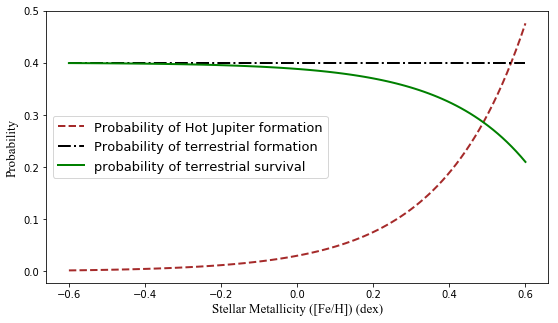

In [2]:
%%time
z = np.linspace(-.6,.6,100)
plt.figure(figsize=(9, 5))

plt.plot(z,[.03*10**(2.0*(i)) for i in z], label='Probability of Hot Jupiter formation', color='brown', linestyle='--',
        linewidth='2')
plt.plot(z,np.ones(100)*.4, label = 'Probability of terrestrial formation', color='black', linestyle='-.', linewidth='2')
plt.plot(z,np.ones(100)*.4*(np.ones(100)-[.03*10**(2.0*(i)) for i in z]), label = 'probability of terrestrial survival',
         color='green', linestyle='-', linewidth='2')

plt.xlabel('Stellar Metallicity ([Fe/H]) (dex)', fontname='Times New Roman', fontsize=13)
plt.ylabel("Probability", fontname='Times New Roman', fontsize=13)
plt.legend(loc = 'best', prop={'size': 13});
# plt.savefig("planetary formation rates")

In [87]:
r = np.arange(3,20,.01) # our radius variable, in units of kpc
std_devs_Z = [0.24,0.22,0.20,0.19,0.18,0.18,.18] #Z standard deviations for each segment of imp_rad
imp_rad = [0,200,400,600,800,1000,1200,1700] #Indices of radii where the Z standard deviation changes
Z_dec_rate = -.04 # slope of metallicity gradient
Z_0 = 0.26 # The y-intercept of the metallicity gradient (i.e. Z(r=0)). the linear function only applies on the disk
HJ_lethality = 0 #probability that Hot Jupiter formation will eliminate existing terrestrial planets
num = 1000 #number of runs to make (>10**4 will run for over a minute, but produce sharper data). All plots in the paper used (num=10**5)
SFR_MW_total = 2.7 #Solar masses per year formed in the MW
SFR = np.array([1.20*(i/8)**-0.12*np.exp(-2.14*(i-8)/8) 
                for i 
                in r]) #solar masses per Gyr/pc^2 at given radii, up to a normalization constant

#calculating the normalization constant A for the SFR by using the known total SFR of the Milky Way
integrated_SFR = np.zeros(len(r))
for i in range(0,len(r)):
    integrated_SFR[i] = 2*np.pi*r[i]*SFR[i]*.01 / (10**9) * (1000**2)
A = SFR_MW_total / np.sum(integrated_SFR)
SFR *= A # Scaling SFR(r) by the normalization factor
avg_SN_zams_mass = 8.5 #average zero-age main sequence mass for a core collapse supernova progenitor
massive_percentage = .006 #fraction of SFR mass used to form stars >8M_sun (i.e. fraction of mass used to generate SN)

In [88]:
%%time
sample_Z = np.zeros((num,1700))
P_ef = np.zeros((num,1700))
P_hj = np.zeros((num,1700))
for n in range(0,num):
    Z = np.array([Z_dec_rate*i+Z_0 for i in r])
    for j in range(0,len(std_devs_Z)):
        temp_err_Z = np.array([np.random.normal(i,std_devs_Z[j])-i 
                               for i 
                               in Z])
        sample_Z[n] = Z + temp_err_Z
        for i in range(imp_rad[j],imp_rad[j+1]):
#             mask1 = np.where(sample_Z[n]>-.6)[0]
#             mask2 = np.where(sample_Z[n]<-.6)[0]
#             P_ef[n][mask1] = .4
#             P_ef[n][mask2] = 0
            if sample_Z[n][i] > -0.6:
                P_ef[n][i] = 0.4
            else:
                P_ef[n][i] = 0
            P_hj[n][i] = .03*10**(2.0*sample_Z[n][i])
    clear_output(wait=True)
    print(str(np.round((n+1)/num*100))+"%")

P_ef_avg = []
P_hj_avg = []
for i in range(0,1700):
    P_ef_avg.append(np.average([P_ef[n][i] for n in range(0,num)]))
    P_hj_avg.append(np.average([P_hj[n][i] for n in range(0,num)]))

100.0%
Wall time: 56.4 s


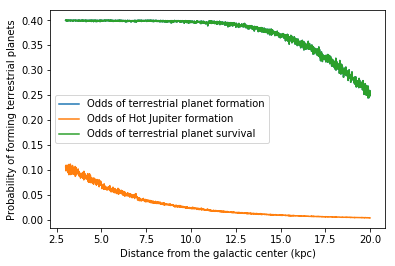

In [89]:
plt.plot(r,P_ef_avg, label = "Odds of terrestrial planet formation")
plt.plot(r,P_hj_avg, label = "Odds of Hot Jupiter formation")
P_es_avg = P_ef_avg*(np.ones(1700)-(np.array(P_hj_avg)*HJ_lethality))
plt.plot(r,P_es_avg, label = "Odds of terrestrial planet survival")
plt.xlabel("Distance from the galactic center (kpc)")
plt.ylabel("Probability of forming terrestrial planets")
plt.legend(loc='best')


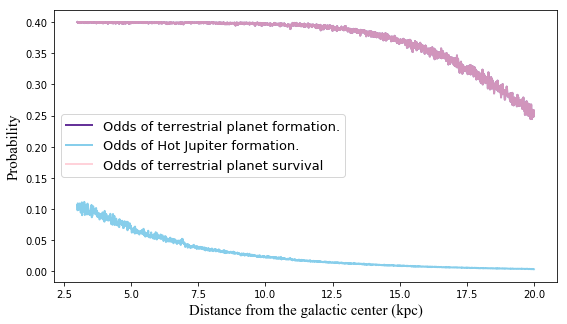

In [90]:
P_es_avg = P_ef_avg*(np.ones(1700)-(np.array(P_hj_avg)*HJ_lethality))
plt.figure(figsize=(9, 5))

plt.plot(r, P_ef_avg, label = "Odds of terrestrial planet formation.", color='rebeccapurple', linewidth='2')
plt.plot(r, P_hj_avg, label = "Odds of Hot Jupiter formation.", color='skyblue', linewidth='2')
plt.plot(r, P_es_avg, label = "Odds of terrestrial planet survival", color='pink', alpha=0.7, linewidth='2')

plt.xlabel("Distance from the galactic center (kpc)", fontname='Times New Roman', fontsize=15)
plt.ylabel("Probability", fontname='Times New Roman', fontsize=15)

plt.legend(loc='best', prop={'size': 13});

In [91]:
%%time
# num = 1000
sample_SN_rate = np.array(np.zeros((num,1700)))
P_surv_SN = np.zeros((num,1700))
# P_ef = np.zeros((num,1700))
# P_hj = np.zeros((num,1700))
for n in range(0,num):
    SN_rate = massive_percentage / avg_SN_zams_mass * SFR #SFR * mass percentage of O & B stars/ average ZAMS mass of SN progenitor in M_sun
    temp_err_SN_rate = np.array([np.random.normal(i,.005)-i for i in SN_rate])
    sample_SN_rate[n] = SN_rate + temp_err_SN_rate
    sample_SN_rate[n] = sample_SN_rate[n] / .01356
    P_surv_SN[n] = -sample_SN_rate[n] / 4 + (9/8)*np.ones(1700)
    for i in range(0,1700):
        if P_surv_SN[n][i] < 0:
            P_surv_SN[n][i] = 0
        elif P_surv_SN[n][i] > 1:
            P_surv_SN[n][i] = 1
    clear_output(wait=True)
    print(str(np.round((n)/num*100))+"%")
        
        
P_surv_SN_avg = []
for i in range(0,1700):
    P_surv_SN_avg.append(np.average([P_surv_SN[n][i] for n in range(0,num)]))
clear_output(wait=True)

Wall time: 15.8 s


Text(11.5, 0.33, '$P_{max}$, 11.37 kpc')

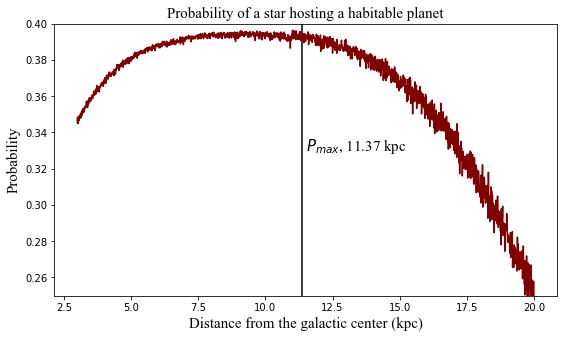

In [92]:
plt.figure(figsize=(9, 5))
P_total = P_es_avg*P_surv_SN_avg
plt.title("Probability of a star hosting a habitable planet", fontname='Times New Roman', fontsize=15)
plt.plot(r,P_total, label = "Total survival odds", color='maroon')
plt.xlabel("Distance from the galactic center (kpc)", fontname='Times New Roman', fontsize=15)
plt.ylabel("Probability", fontname='Times New Roman', fontsize=15)
plt.vlines(11.37,.25,.4)
plt.ylim(.25,.4)
plt.text(11.5,0.33,"$P_{max}$, 11.37 kpc",fontname='Times New Roman', fontsize=15)
# plt.xlabel("Distance from the galactic center (kpc)")
# plt.ylabel("Probability")
# plt.legend();
# plt.savefig("Galactic Survival Rate")

[9.06]


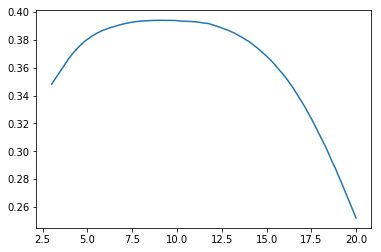

In [93]:
smooth_P_total = savgol_filter(P_total,155,1)
plt.plot(r,smooth_P_total)
# plt.xlim(0,20)
# plt.ylim(0,0.5)
print(r[np.where(smooth_P_total == np.max(smooth_P_total))[0]])


In [10]:
# from ipywidgets import interact
# def find_window_size(ws):
#     smooth_P_total = savgol_filter(P_total,ws*2+1,1)
#     plt.plot(r,smooth_P_total)
# interact(find_window_size, ws = 25)

In [11]:
SFR = [A*1.20*(i/8)**-0.12*np.exp(-2.14*(i-8)/8) for i in r] #solar masses per Gyr/pc^2 at given radii
SFR_numbers = np.array(SFR) / 0.5 *1000**2 #stars per Gyr per kpc**2
SFR_life = SFR_numbers * smooth_P_total * r * 2*np.pi

(0, 260000000.0)

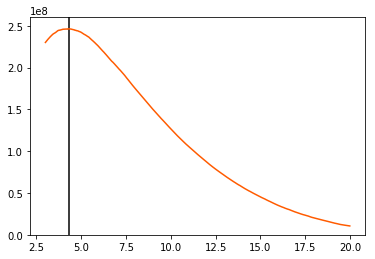

In [12]:
plt.plot(r,SFR_life,color='xkcd:bright orange')
weighted_max = r[np.where(SFR_life == np.max(SFR_life))]
plt.vlines(weighted_max,0,2.6e8)
plt.ylim(0, 2.6e8)

In [13]:
r = np.arange(3,20,.01)
total_planets = np.zeros(len(r))
for i in range(len(r)):
    if i>0:
        total_planets[i] = SFR_life[i] * .01
np.sum(total_planets) / (10**9)

1.9492874645687728

array([ 1.20148668, -0.1183109 ,  2.13858808])

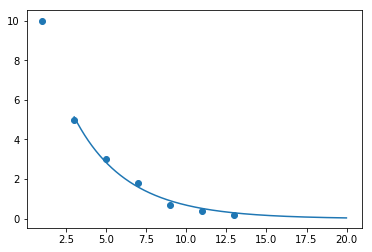

In [14]:
# r = np.arange(3,20,.01)
r_SFR = [1,3,5,7,9,11,13]
SFR_r = [10,5,3,1.8,.7,.4,.2]
plt.scatter(r_SFR,SFR_r)
def exp_fit(x,a,b,c):
    return a*np.e**(b*x) + c
#kubryk and Prantzos
def sfr_fit(x,a,c,d):
    return a*(x/8)**c*np.exp(-d*((x-8)/8))

fitpars,error = curve_fit(sfr_fit,r_SFR,SFR_r)
plt.plot(r,sfr_fit(r,*fitpars))
fitpars

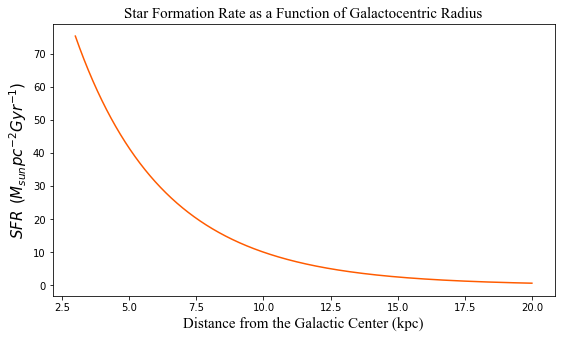

In [15]:
plt.figure(figsize=(9, 5))

plt.plot(r,np.array(SFR)*A,color='xkcd:bright orange')
plt.ylabel("$SFR \>\>(M_{sun} pc^{-2}Gyr^{-1})$",fontname='Times New Roman', fontsize=15)
plt.xlabel("Distance from the Galactic Center (kpc)",fontname='Times New Roman', fontsize=15)
plt.title("Star Formation Rate as a Function of Galactocentric Radius",fontname='Times New Roman', fontsize=15);

In [71]:
.006/8.5*SFR[500]

0.0032417193832784447

In [72]:
r[500]

7.999999999999893